# Task 1 : Set up colab gpu runtime environment

In [280]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1w7505ts
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1w7505ts
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [281]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


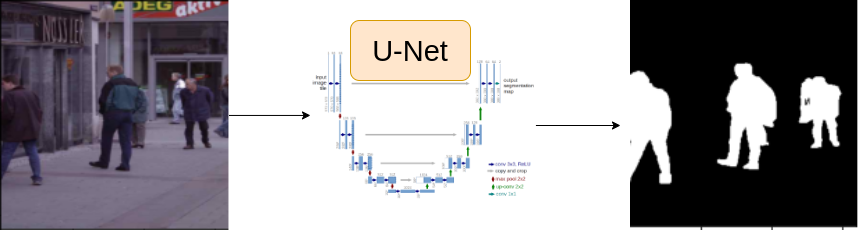

# Some Common Imports

In [282]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [283]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [329]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cuda"

EPOCHS = 50
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [285]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [286]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


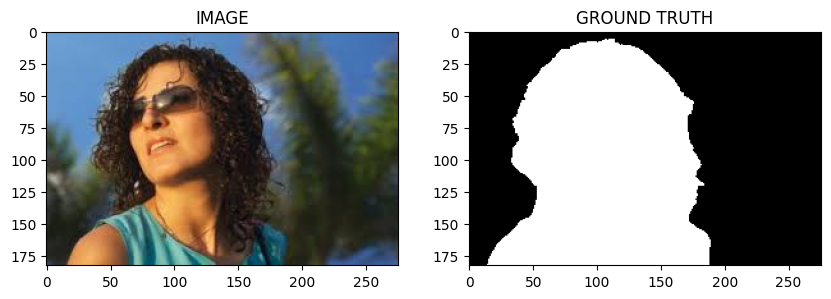

In [287]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [288]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [289]:
import albumentations as A

In [290]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ],is_check_shapes= False)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [291]:
from torch.utils.data import Dataset

In [292]:
class SegmentationDataset(Dataset):
  def __init__(self,df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data["image"]
      mask = data["mask"]

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [293]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [294]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


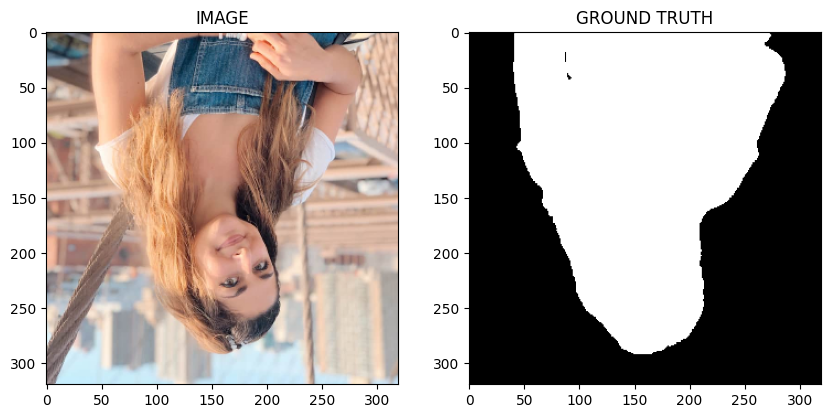

In [295]:
idx = 23

image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [296]:
from torch.utils.data import DataLoader

In [297]:
trainloader = DataLoader(trainset, BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset, BATCH_SIZE)


In [298]:
print("Total no. of batches in trainlaoder:", len(trainloader))
print("Total no. of batches in validlaoder:", len(validloader))


Total no. of batches in trainlaoder: 15
Total no. of batches in validlaoder: 4


In [299]:
for image, mask in trainloader:
  break
print("one batch image shape:",image.shape)
print("one batch mask shape:",mask.shape)

one batch image shape: torch.Size([16, 3, 320, 320])
one batch mask shape: torch.Size([16, 1, 320, 320])



# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [300]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [317]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
        )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks!= None:
      loss1 = DiceLoss(mode = "binary")(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [310]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [318]:
def train_func(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(data_loader)


In [319]:
def eval_func(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

      return total_loss / len(data_loader)

# Task 8 : Train Model

In [320]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [333]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_func(data_loader = trainloader,model = model,optimizer = optimizer)
  valid_loss = eval_func(validloader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("SAVED_MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} train_loss: {train_loss}and valid_loss: {valid_loss}")

  0%|          | 0/4 [00:00<?, ?it/s]


SAVED_MODEL
Epoch: 1 train_loss: 0.01325145959854126and valid_loss: 0.03442759066820145


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED_MODEL
Epoch: 2 train_loss: 0.012654552857081095and valid_loss: 0.033982083201408386


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 3 train_loss: 0.01646351714928945and valid_loss: 0.03452986478805542


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 4 train_loss: 0.008147528767585755and valid_loss: 0.03633856773376465


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 5 train_loss: 0.008538285891215006and valid_loss: 0.04108631983399391


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 6 train_loss: 0.018222455183664957and valid_loss: 0.045023757964372635


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 7 train_loss: 0.014875285824139913and valid_loss: 0.04802617430686951


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 8 train_loss: 0.013030803203582764and valid_loss: 0.04537227377295494


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 9 train_loss: 0.011686170101165771and valid_loss: 0.03911101818084717


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 10 train_loss: 0.018368872006734212and valid_loss: 0.040014587342739105


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 11 train_loss: 0.008453765511512756and valid_loss: 0.04184965416789055


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 12 train_loss: 0.009272950887680053and valid_loss: 0.04155232757329941


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 13 train_loss: 0.014870110154151916and valid_loss: 0.042114175856113434


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 14 train_loss: 0.01731607913970947and valid_loss: 0.044493623077869415


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 15 train_loss: 0.01717383066813151and valid_loss: 0.04553869366645813


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 16 train_loss: 0.018714000781377155and valid_loss: 0.038561463356018066


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 17 train_loss: 0.011301204562187195and valid_loss: 0.04149492830038071


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 18 train_loss: 0.012099124987920125and valid_loss: 0.04983464628458023


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 19 train_loss: 0.011901996533075969and valid_loss: 0.05691258981823921


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 20 train_loss: 0.014116070667902629and valid_loss: 0.05793490633368492


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 21 train_loss: 0.009537733594576518and valid_loss: 0.05438407137989998


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 22 train_loss: 0.008377880851427714and valid_loss: 0.0484519898891449


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 23 train_loss: 0.015035360058148702and valid_loss: 0.04206079617142677


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 24 train_loss: 0.013474013408025105and valid_loss: 0.03848831355571747


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 25 train_loss: 0.011257519324620565and valid_loss: 0.03912018612027168


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 26 train_loss: 0.01775828202565511and valid_loss: 0.04113738238811493


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 27 train_loss: 0.017153632640838624and valid_loss: 0.040762435644865036


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 28 train_loss: 0.022620811065038045and valid_loss: 0.040334802120923996


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 29 train_loss: 0.010298112034797668and valid_loss: 0.041770778596401215


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 30 train_loss: 0.017956046263376872and valid_loss: 0.04498680308461189


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 31 train_loss: 0.007592888673146566and valid_loss: 0.05168582499027252


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 32 train_loss: 0.016202213366826375and valid_loss: 0.05090267211198807


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 33 train_loss: 0.01723084052403768and valid_loss: 0.04834038019180298


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 34 train_loss: 0.008828738331794738and valid_loss: 0.046303607523441315


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 35 train_loss: 0.009616005420684814and valid_loss: 0.04595859348773956


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 36 train_loss: 0.018476653099060058and valid_loss: 0.04524978995323181


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 37 train_loss: 0.009548793236414591and valid_loss: 0.04667229205369949


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 38 train_loss: 0.00874783992767334and valid_loss: 0.048510774970054626


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 39 train_loss: 0.010110686222712198and valid_loss: 0.04889780282974243


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 40 train_loss: 0.017119820912679037and valid_loss: 0.04860534891486168


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 41 train_loss: 0.01695032517115275and valid_loss: 0.04753030836582184


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 42 train_loss: 0.007075265049934387and valid_loss: 0.04515964910387993


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 43 train_loss: 0.008550604184468588and valid_loss: 0.04312640801072121


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 44 train_loss: 0.01361578404903412and valid_loss: 0.041604429483413696


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 45 train_loss: 0.007765459517637889and valid_loss: 0.04068448767066002


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 46 train_loss: 0.009258821606636047and valid_loss: 0.04036073386669159


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 47 train_loss: 0.008180160323778789and valid_loss: 0.03912137821316719


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 48 train_loss: 0.009705231587092081and valid_loss: 0.03751539811491966


  0%|          | 0/4 [00:00<?, ?it/s]


SAVED_MODEL
Epoch: 49 train_loss: 0.011998472611109416and valid_loss: 0.03385967016220093


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 50 train_loss: 0.008088533580303193and valid_loss: 0.03392350673675537


# Task 9 : Inference

In [331]:
idx = 20

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask >0.5)* 1.0

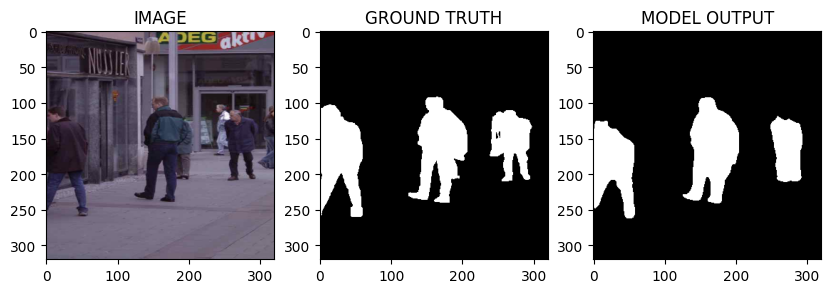

In [332]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya